# Demonstrating Atmospheric Turbulence Perturbations

## Introduction
This notebook is part of the NRTK demonstration suite, demonstrating how perturbations can be applied and their impact measured via MAITE evaluation workflows.

## Layout
This notebook demonstrates how a particular condition (in this case, <b><i>atmospheric turbulence</i></b>), can affect an object detection model, and how that impact can be measured. The overall structure is:

- **Traditional vs. relative mAP:**
    - An overview of the nuances of what we'll be evaluating.
- **Setup:**
    - Notebook initialization, loading the supporting python code. Depending on if this is the first time you've run this notebook, this may take some time.
    - Loading the source image, which will be used throughout the notebook.
- **Image perturbation examples:**
    - The NRTK perturbation is demonstrated on the source image.
- **Baseline detections:**
    - The object detection model is loaded and run on the unperturbed image. These will serve as \"ground truth\" for comparisons against the perturbed images.
 
At this point, we have the fundamental elements of our evaluation: the model, our reference image, and a mechanism for creating the perturbed test images. Next we adapt these elements to be used with the MAITE evaluation workflow:

- **Wrapping the detection model**
- **Wrapping the reference image as a dataset**
- **Wrapping the perturbation as augmentation objects**
- **Wrapping the metrics**

After the evaluation elements have been wrapped, we can run the evaluation:

- **Preparing the augmentations:**
    - We specify the range of perturbation values to evaluate and optionally specify which ones we'd like to visualize.
- **Evaluation of augmented data:**
    - Each augmentation is run through MAITE's evaluation workflow, computing the mean average precision metric relative to the unperturbed detections.
- **Evaluation analysis:**
    - We plot and discuss the mAP@50 metric from each of the perturbed images, as well as per-class and per-area results.

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/nrtk/blob/main/docs/examples/maite/nrtk_turbulence_perturber_demo.ipynb)

# Evaluation guidance: traditional vs. relative mAP

This notebook will be evaluating the perturbed images using mean average precision (mAP) **relative** to detections from the unperturbed image. Traditional mAP scores the computed detections to ground-truth annotations vetted by an analyst; the mAP metric indicates how well the detector does compared to that analyst and thus measures the detector's "absolute" performance ("absolute" in the sense that the assumption is no detector can do better than the analyst.)

In contrast, in this notebook, we're not concerned with the **absolute** ability of the detector to find objects of interest. Rather, we're interested in how the **perturbations** affect the detector *relative to the unperturbed image*. It's expected that the detector won't find every target in the unperturbed image; instead, we're measuring the **change in the detections** (or classifications) caused by the perturbations.

To support relative mAP, we'll be computing detections on the unperturbed image and using those as our "ground truth" dataset, and using the MAITE dataset class slightly differently than usual. For example, there's no on-disk json file of reference annotations with an associated data loader; instead, we'll be taking the computed detections and manually copying them over into the dataset.

# Setup: Notebook initialization
The next few cells import the python packages used in the rest of the notebook.

**Note:** We are suppressing warnings within this notebook to reduce visual clutter for demonstration purposes. If any issues arise while executing this notebook, we recommend that the first cell is **not** executed so that any related warnings are shown.

In [1]:
from __future__ import annotations

# warning suppression
import warnings

warnings.filterwarnings("ignore")

In [2]:
import sys  # noqa: F401

print("Beginning package installation...")
!{sys.executable} -m pip install -qU pip

print("Installing required packages...")
!{sys.executable} -m pip install -q "nrtk[pybsm,maite]" --no-cache-dir
!{sys.executable} -m pip install -q "matplotlib" --no-cache-dir
!{sys.executable} -m pip install -q "torchvision" --no-cache-dir
!{sys.executable} -m pip install -q "torchmetrics" --no-cache-dir
!{sys.executable} -m pip install -q "ultralytics" --no-cache-dir
# OpenCV must be uninstalled and reinstalled last due to other packages installing OpenCV
print("Doing a fresh install of opencv-python-headless...")
!{sys.executable} -m pip uninstall -qy opencv-python  opencv-python-headless
!{sys.executable} -m pip install -q opencv-python-headless --no-cache-dir

Beginning package installation...
Installing required packages...
Doing a fresh install of opencv-python-headless...


In [3]:
import os
import urllib.request
from collections.abc import Sequence
from typing import Any

import numpy as np

# some initial imports
%matplotlib inline
%config InlineBackend.figure_format = "jpeg"  # Use JPEG format for inline visualizations

from matplotlib import pyplot as plt
from PIL import Image

from nrtk.impls.perturb_image.pybsm.turbulence_aperture_otf_perturber import TurbulenceApertureOTFPerturber

# Setup: Source image

In the next cell, we'll download and display a source image from the __[VisDrone](https://github.com/VisDrone/VisDrone-Dataset)__ dataset. The image will be cached in a local `data` subdirectory.

### A note on image storage

Typically in ML workflows, batches of images are processed as tensors of the color channels. Both our perturber (NRTK) and object detector (YOLO) accept numpy `ndarray` objects, and we will use [matplotlib.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) to view them. The complication is that although YOLO inferences on `ndarray`, [it expects the color channels to be in BGR](https://docs.ultralytics.com/modes/predict/) order. If we naively view the same data YOLO inferences on, the colors will be wrong; if we naively inference on what we view, the detections will be wrong. (Our NRTK perturbation is agnostic to the channel order.)

In this notebook, we'll convert the channel order to BGR when we load, and convert back whenever we explicitly call `imshow`.


0.20.0


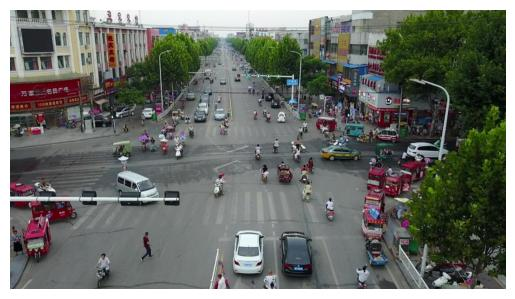

In [4]:
import nrtk

print(nrtk.__version__)
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)
img_path = os.path.join(data_dir, "visdrone_img.jpg")
if not os.path.isfile(img_path):
    url = "https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download"
    _ = urllib.request.urlretrieve(url, img_path)  # noqa: S310

img_pil = Image.open(img_path)
img_nd_bgr = np.asarray(img_pil)[
    :,
    :,
    ::-1,
]  # tip o' the hat to https://stackoverflow.com/questions/4661557/pil-rotate-image-colors-bgr-rgb
plt.figure()
plt.axis("off")

_ = plt.imshow(img_nd_bgr[:, :, ::-1])  # explicitly changing BGR to RGB for imshow

# NRTK Turbulence Aperture perturbation: examples and guidance

The [Turbulence Aperture perturbation](https://jatic.pages.jatic.net/kitware/nrtk/_implementations/nrtk.impls.perturb_image.pybsm.turbulence_aperture_otf_perturber.html) is set by the following parameters:

- `mtf_wavelengths`: a sequence of wavelengths (m)
- `mtf_weights`: a sequence of weights for each wavelength contribution (arb)
- `altitude`: height of the aircraft above the ground (m)
- `slant_range`: line-of-sight range between the aircraft and target (target is assumed to be on the ground) (m)
- `D`: effective aperture diameter (m)
- `ha_wind_speed`: the high altitude windspeed (m/s); used to calculate the turbulence profile
- `cn2_at_1m`: the refractive index structure parameter "near the ground" (e.g. at h = 1 m); used to calculate the turbulence profile
- `int_time`: dwell (i.e. integration) time (seconds)
- `n_tdi`: the number of time-delay integration stages (relevant only when TDI cameras are used. For CMOS cameras, the value can be assumed to be 1.0)
- `aircraft_speed`: apparent atmospheric velocity (m/s); this can just be the windspeed at the sensor position if the sensor is stationary

The following are default values for these parameters when not supplied:

- `mtf_wavelengths = [0.50e-6, 0.66e-6]`
- `mtf_weights = [1.0, 1.0]`
- `altitude = 250`
- `slant_range = 250  # slant_range = altitude`
- `D = 40e-3`
- `ha_wind_speed = 0`
- `cn2_at_1m = 1.7e-14`
- `int_time = 30e-3`
- `n_tdi = 1.0`
- `aircraft_speed = 0`

For the purpose of this example notebook, we will only change the `cn2_at_1m` value. All other parameters will use the values from the original image.

Changing the value of `cn2_at_1m` will have the following affects: 
- `cn2_at_1m == 1.7e-14` (the original value): returns the original image unchanged.
- `cn2_at_1m > 1.7e-14`: returns an image more turbulent than the original image. There is no upper bound, but values greater than ~1e-7 (for this image) can be less turbulent or blank.

Please note for this example image, `cn2_at_1m < 1.7e-14` will produce the original image and should not be used.
  

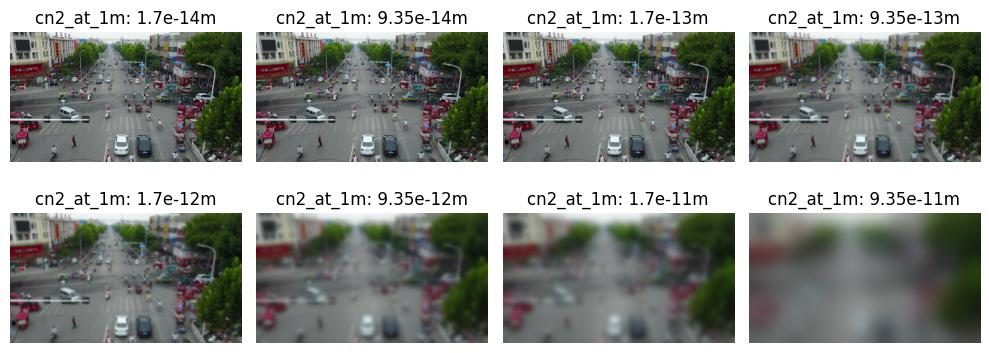

In [19]:
_, ax = plt.subplots(2, 4, figsize=(10, 4))
for idx, cn2_at_1m in enumerate((1.7e-14, 9.35e-14, 1.7e-13, 9.35e-13, 1.7e-12, 9.35e-12, 1.7e-11, 9.35e-11)):
    (row, col) = (int(idx / 4), idx % 4)
    perturber = TurbulenceApertureOTFPerturber(cn2_at_1m=cn2_at_1m)
    ax[row, col].set_title(f"cn2_at_1m: {cn2_at_1m}m")
    ax[row, col].imshow(perturber(img_nd_bgr)[0][:, :, ::-1])
    _ = ax[row, col].axis("off")
plt.tight_layout()

# Baseline detections

In the next cell, we'll download a [YOLOv11](https://docs.ultralytics.com/models/yolo11/) model, compute object detections on the source image, and display the results. As discussed above, these detections will serve as the "ground truth" for our relative mAP evaluation later.

*Note that here, we're using YOLO's built-in visualization tool, which automatically adjusts for BGR / RGB order.*

In [6]:
# Import YOLO support
import ultralytics

ultralytics.checks()
print("Downloading model...")
model = ultralytics.YOLO("yolo11n.pt")
print("Computing baseline...")
baseline = model(img_nd_bgr)

Ultralytics 8.3.85 🚀 Python-3.10.12 torch-2.6.0+cu124 CPU (11th Gen Intel Core(TM) i9-11950H 2.60GHz)
Setup complete ✅ (16 CPUs, 62.5 GB RAM, 328.9/914.7 GB disk)
Computing baseline...

0: 384x640 5 persons, 15 cars, 1 motorcycle, 2 trucks, 52.9ms
Speed: 3.9ms preprocess, 52.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


# MAITE Evaluation workflow preparation

We'll use the [MAITE Evaluation workflow](https://jatic.pages.jatic.net/cdao/maite/generated/maite.workflows.evaluate.html) to evaluate the performance of the perturbed data against our baseline detections. We'll need to "wrap" our model, data, and perturbations into callable objects to pass to the `maite.workflows.evaluate` function:

- We'll wrap the **model** to make predictions on input data when called.

- The wrapped **dataset** will return our test image when called. Note that this will be the original, unperturbed image; we'll apply our perturbations via...

- ...the **augmentation** object, which applies the perturbation to the image inside the evaluation.

- Finally, the **metric** object will define our precise scoring methodology.

The evaluation workflow in this notebook is slightly unusual. Typical ML workflows apply many different augmentations / perturbations to much larger datasets, and only call `evaluate` once to get a statistical view of performance. But since the goal of this notebook is to drill down into how perturbation affects performance, we've essentially flipped process, calling `evaluate` (and thus our wrapped objects) many times, once per loop on our single image perturbed to a known degree, and then observing how the metrics respond.

## Some helper classes

The following cell adds two classes to allow us to use YOLO detections with the MAITE evaluation workflow:

1. The `YOLODetectionTarget` helper class that stores the bounding boxes, label indices, and confidence scores for a single image's detections.

2. The `MaiteYOLODetection` adapter class that conforms to the MAITE [Object Detection Dataset](https://jatic.pages.jatic.net/cdao/maite/generated/maite.protocols.object_detection.Dataset.html) protocol by providing the `__len__` and `__getitem__` methods. The returned item is a tuple of (image, `YOLODetectionTarget`, metadata-dictionary).

In [7]:
from dataclasses import dataclass

import torch
from maite.protocols.object_detection import DatumMetadataType

from nrtk.interop.maite.interop.object_detection.dataset import JATICObjectDetectionDataset

##
## Helper class for containing the boxes, label indices, and confidence scores.
##


@dataclass
class YOLODetectionTarget:
    """A helper class to represent object detection results in the format expected by YOLO-based models.

    Attributes:
        boxes (torch.Tensor): A tensor containing the bounding boxes for detected objects in
            [x_min, y_min, x_max, y_max] format.
        labels (torch.Tensor): A tensor containing the class labels for the detected objects.
            These may be floats for compatibility with specific datasets or tools.
        scores (torch.Tensor): A tensor containing the confidence scores for the detected objects.
    """

    boxes: torch.Tensor
    labels: torch.Tensor
    scores: torch.Tensor


##
## Prepare results for ingestion into maite dataset by puttin them into detection object
## Images must be channel first (c, h, w) in maite dataset objects
##
imgs = [np.transpose(img_nd_bgr, (2, 0, 1))]
dets = []
metadata: list[DatumMetadataType] = [{"id": 0}]
for _detection in baseline:
    boxes = baseline[0].boxes.xyxy.cpu()
    labels = baseline[0].boxes.cls.cpu()  # note, these are floats, not ints
    scores = baseline[0].boxes.conf.cpu()

    dets.append(YOLODetectionTarget(boxes, labels, scores))

## (1) Wrapping the detection model

The first object we'll wrap will be the detection model. The cell below defines a class adapting YOLO for the [MAITE Object Detection Model](https://jatic.pages.jatic.net/cdao/maite/generated/maite.protocols.object_detection.Model.html) protocol. The `__call__` method runs the model on images in the batch and is called by the MAITE evaluation workflow later in the notebook.

In [ ]:
import maite.protocols.object_detection as od
import ultralytics.models
from maite.protocols import ArrayLike, ModelMetadata


class MaiteYOLODetector:
    """A wrapper class for a YOLO model to simplify its usage with input batches and object detection targets.

    This class takes a YOLO model instance, processes input image batches, and converts predictions into
    `YOLODetectionTarget` instances.

    Attributes:
        _model (ultralytics.models.yolo.model.YOLO): The YOLO model instance used for predictions.

    Methods:
        __call__(batch):
            Processes a batch of images through the YOLO model and returns the predictions as
            `YOLODetectionTarget` instances.
    """

    def __init__(self, model: ultralytics.models.yolo.model.YOLO) -> None:
        """Initializes the MaiteYOLODetector with a YOLO model instance.

        Args:
            model (ultralytics.models.yolo.model.YOLO): The YOLO model to use for predictions.
        """
        self._model = model
        # Dummy model metadata type to pass type checking
        self.metadata = ModelMetadata(id="0")

    def __call__(self, batch: Sequence[ArrayLike]) -> Sequence[YOLODetectionTarget]:
        """Processes a batch of images using the YOLO model and converts the predictions to `YOLODetectionTarget`s.

        Args:
            batch (Sequence[ArrayLike]): A batch of images in (c, h, w) format (channel-first).

        Returns:
            Sequence[YOLODetectionTarget]: A list of YOLODetectionTarget instances containing the predictions for each
            image in the batch.
        """
        # Convert images to channel-last format (h, w, c) for YOLO model
        batch_transposed = [np.transpose(batch[i], (1, 2, 0)) for i in range(len(batch))]

        yolo_predictions = self._model(batch_transposed, verbose=False)
        return [
            YOLODetectionTarget(
                p.boxes.xyxy.cpu(),  # Bounding boxes in (x_min, y_min, x_max, y_max) format
                p.boxes.cls.cpu(),  # Class indices for the detected objects
                p.boxes.conf.cpu(),  # Confidence scores for the detections
            )
            for p in yolo_predictions
        ]


# create the wrapped model object
yolo_model: od.Model = MaiteYOLODetector(model)

## (2) Wrapping the dataset

MAITE pairs images and their reference detections (aka targets, ground truth) into **datasets**. Typical ML workflows have many images per dataset; when these do not all fit in memory simultaneously, a *dataloader* object is used which can page images and annotations in from disk. For this notebook, however, each invocation of `evaluate` will use the same single-image dataset (our reference image with its baseline detections.)

In [9]:
# our single image, its baseline detections, and metadata dictionary
# switch image to channel first
single_image_dataset: od.Dataset = JATICObjectDetectionDataset(imgs, dets, metadata, dataset_id="visdrone_ex")

## (3) Wrapping the perturbations as augmentations

The `evaluate` function will perturb the image from the dataset using instances of the class defined below, one instance per perturbation value. Note that the object doesn't perform any augmentations until called by the `evaluate` workflow.

In [10]:
from nrtk.interop.maite.interop.object_detection.augmentation import JATICDetectionAugmentation

perturber = TurbulenceApertureOTFPerturber(cn2_at_1m=1.7e-14)
identity_augmentation = JATICDetectionAugmentation(perturber, augment_id="identity")

## (4) Wrapping the metrics

We'll compare the detections in each perturbed image to the unperturbed detections using the Mean Average Precision (mAP) metric from the `torchmetrics` package. The following cell creates a mAP metrics object, wraps it in a MAITE [MAITE Object Detection Metric](https://jatic.pages.jatic.net/cdao/maite/generated/maite.protocols.object_detection.Metric.html) protocol-compatible class, and then creates an instance of this class, which will be called by `evaluate`.

This code is copied directly from the [MAITE object detection tutorial](https://jatic.pages.jatic.net/cdao/maite/tutorials/torchvision_object_detection.html#metrics) (with the exception of setting `class_metrics=True`.)

In [ ]:
from maite.protocols import MetricMetadata
from torchmetrics import Metric as TorchMetric
from torchmetrics.detection.mean_ap import MeanAveragePrecision

##
## Create an instance of the MAP metric object
##

tm_metric = MeanAveragePrecision(
    box_format="xyxy",
    iou_type="bbox",
    iou_thresholds=[0.5],
    rec_thresholds=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    max_detection_thresholds=[1, 10, 100],
    class_metrics=True,
    extended_summary=False,
    average="macro",
)

##
## This wrapper associates the MAP metric object with methods called by the evaluate
## workflow to accumulate detection data and compute the metrics.
##


class WrappedTorchmetricsMetric:
    """A wrapper class for a Torchmetrics metric designed to simplify its usage for object detection tasks.

    This class facilitates the conversion of object detection targets and predictions into the format
    expected by Torchmetrics metrics, allowing for easier integration with existing pipelines.

    Attributes:
        _tm_metric (Callable): The Torchmetrics metric to be wrapped, which takes lists of dictionaries
            containing torch.Tensor objects representing predictions and targets.

    Methods:
        to_tensor_dict(target):
            Converts an `ObjectDetectionTarget` into a dictionary format compatible with the Torchmetrics
            metric's `update` method.

        update(preds, targets):
            Updates the wrapped Torchmetrics metric with batches of predictions and targets in their native format.

        compute():
            Computes the final metric values using the wrapped Torchmetrics metric.

        reset():
            Resets the state of the wrapped Torchmetrics metric.
    """

    def __init__(
        self,
        tm_metric: TorchMetric,
    ) -> None:
        """Initializes the WrappedTorchmetricsMetric with the given Torchmetrics metric.

        Args:
            tm_metric (Callable): A Torchmetrics metric instance that expects predictions and targets as lists of
                dictionaries containing torch.Tensor objects.
        """
        self._tm_metric = tm_metric
        # Dummy metric metadata type to pass type checking
        self.metadata = MetricMetadata(id="0")

    @staticmethod
    def to_tensor_dict(target: od.ObjectDetectionTarget) -> dict[str, torch.Tensor]:
        """Converts an ObjectDetectionTarget into a dictionary format compatible with the Torch's `update` method.

        Args:
            target (od.ObjectDetectionTarget): An object detection target instance containing boxes, labels, and scores.

        Returns:
            dict[str, torch.Tensor]: A dictionary with keys `boxes`, `scores`, and `labels`, each mapping to a tensor.
        """
        return {
            "boxes": torch.as_tensor(target.boxes),
            "scores": torch.as_tensor(target.scores),
            "labels": torch.as_tensor(target.labels).type(torch.int64),
        }

    def update(self, preds: od.TargetBatchType, targets: od.TargetBatchType) -> None:
        """Updates the wrapped Torchmetrics metric with the given predictions and targets.

        Args:
            preds (od.TargetBatchType): A batch of predictions in the format expected by the Torchmetrics metric.
            targets (od.TargetBatchType): A batch of targets in the format expected by the Torchmetrics metric.
        """
        preds_tm = [self.to_tensor_dict(pred) for pred in preds]
        targets_tm = [self.to_tensor_dict(tgt) for tgt in targets]
        self._tm_metric.update(preds_tm, targets_tm)

    def compute(self) -> dict[str, Any]:
        """Computes and returns the final metric values using the wrapped Torchmetrics metric.

        Returns:
            dict[str, Any]: A dictionary containing the computed metric values.
        """
        return self._tm_metric.compute()

    def reset(self) -> None:
        """Resets the state of the wrapped Torchmetrics metric, clearing any accumulated data."""
        self._tm_metric.reset()


##
## This is our instance variable that can compute the MAP metrics.
##

mAP_metric: od.Metric = WrappedTorchmetricsMetric(tm_metric)  # noqa: N816

# Running the evaluation

We now have all the wrappings required to evaluate our range of perturbations:
- The `yolo_model` object, wrapping the YOLO model
- The `single_image_dataset` object, providing our source image and its baseline detections
- The `augmentation` object, which when instantiated, applies a single perturbation value to its input
- The `mAP_metrics` object, defining the metrics to compute at each perturbation value

## Evaluation sanity check: ground truth against itself

Here we quickly check the evaluation workflow by creating an *identity augmentation* (with a cn2_at_1m value of 1.7e-14, leaving the image unchanged) and scoring it.  The detections should also be unchanged from the baseline and thus give an mAP of 1.0.

In [12]:
from maite.workflows import evaluate

# call the model for each image in the dataset (in this case, just the source image),
# scoring the resulting detections against those from the dataset
sanity_check_results, _, _ = evaluate(
    model=yolo_model,
    dataset=single_image_dataset,
    augmentation=identity_augmentation,
    metric=mAP_metric,
)

print("Sanity check: overall mAP (should be 1.0):", sanity_check_results["map"].item())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]

Sanity check: overall mAP (should be 1.0): 1.0


## Preparing the data

Now we'll prepare the augmentation instances for the evaluation. In the cell below, you can set three parameters for sweeping the set of perturbation values:
- **sweep_low**: the minimum perturbation value (must be >= 1.7e-14)
- **sweep_high**: the maximum perturbation value
- **sweep_count**: how many perturbations to generation

You can also optionally select perturbations to visualize:
- **visualization_indices**: a list of perturbation indices *p*, 0 <= *p* < sweep_count. These instances will be rendered along with their corresponding detections.

In [13]:
SWEEP_LOW = 1.7e-14
SWEEP_HIGH = 1.7e-12
SWEEP_COUNT = 30
VISUALIZATION_INDICES = [3, 9, 21]

##
## end user-settable parameters
##

perturbation_values = np.linspace(SWEEP_LOW, SWEEP_HIGH, SWEEP_COUNT, endpoint=True)
augmentations = [
    JATICDetectionAugmentation(TurbulenceApertureOTFPerturber(cn2_at_1m=p), augment_id=str(idx))
    for idx, p in enumerate(perturbation_values)
]

print(f"Generated {len(augmentations)} perturbation augmentations")

Generated 30 perturbation augmentations


## Calling evaluate on the augmented data

We loop over all the augmentations, calling `evaluate` on each one and building up a list of resulting metrics for analysis.

Any augmentation indices specified above will be rendered in this step.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


Perturbation #3: cn2_at_1m perturbation value 1.911e-13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Perturbation #9: cn2_at_1m perturbation value 5.3931e-13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


Perturbation #21: cn2_at_1m perturbation value 1.2357e-12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


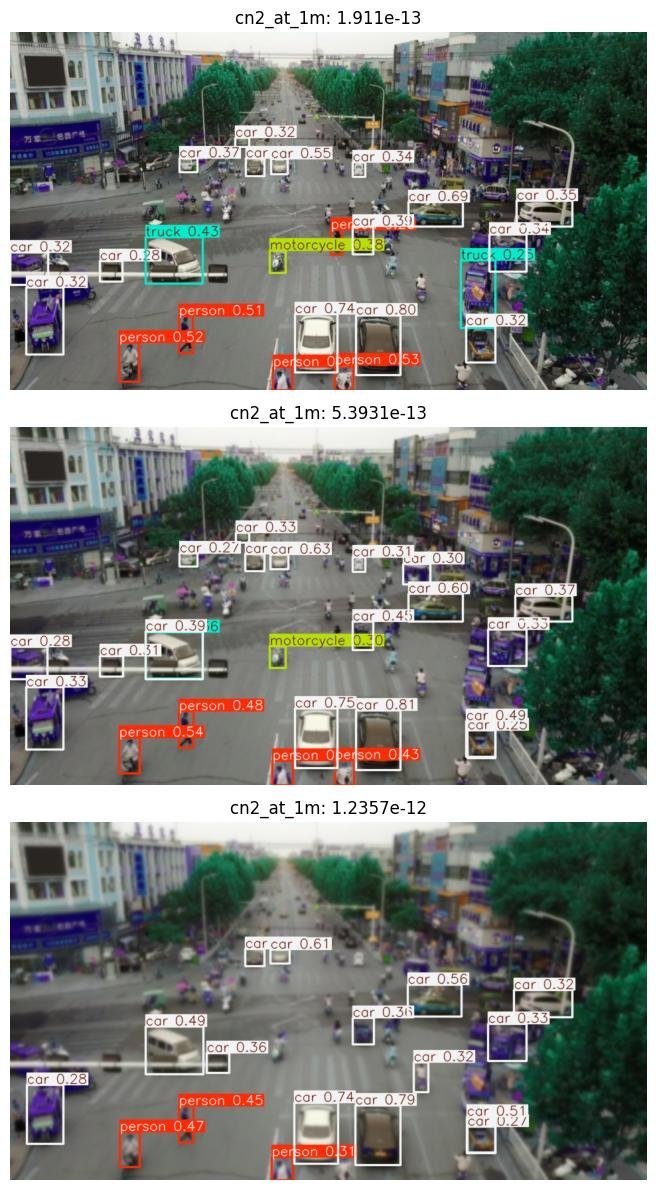

In [18]:
perturbed_metrics = list()
_, ax = plt.subplots(len(VISUALIZATION_INDICES), figsize=(30, 12))
for idx, a in enumerate(augmentations):
    # reset the metric object for each dataset
    mAP_metric.reset()
    result, _, _ = evaluate(model=yolo_model, dataset=single_image_dataset, augmentation=a, metric=mAP_metric)
    perturbed_metrics.append(result)

    if idx in VISUALIZATION_INDICES:
        # quickest way is to re-evaluate
        cn2_at_1m = a.augment.get_config()["cn2_at_1m"]
        print(f"Perturbation #{idx}: cn2_at_1m perturbation value {cn2_at_1m:0.5}")
        datum = single_image_dataset[0]
        batch = ([datum[0]], [datum[1]], [datum[2]])
        # Extract the image from the augmentation and switch it to channel last
        aug = np.transpose(a(batch)[0][0], (1, 2, 0))
        # Plot image
        ax_idx = VISUALIZATION_INDICES.index(idx)
        ax[ax_idx].imshow(model(aug)[0].plot())
        ax[ax_idx].set_title(f"cn2_at_1m: {cn2_at_1m:0.5}")
        _ = ax[ax_idx].axis("off")
plt.tight_layout()

# Evaluation analysis

Now we can plot how the metrics (for example, mAP @ IoU=50) vary with perturbation level, keeping in mind this is a **relative** mAP against the detections in the unperturbed image.


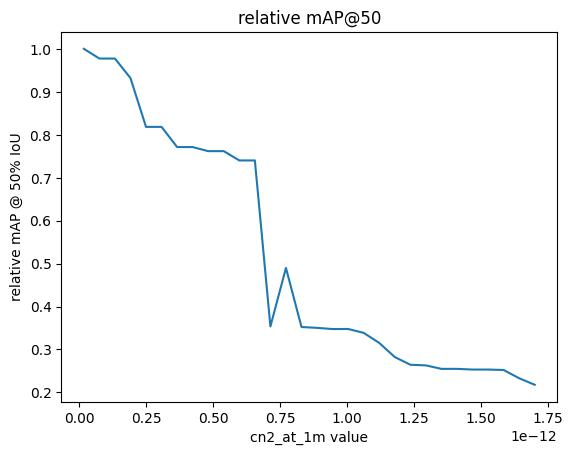

In [15]:
map50_list = [m["map_50"].item() for m in perturbed_metrics]
plt.title("relative mAP@50")
plt.xlabel("cn2_at_1m value")
plt.ylabel("relative mAP @ 50% IoU")
_ = plt.plot(perturbation_values, map50_list)

## Evaluation interpretation

The metric shown, mAP@50, is the average precision of detections across all classes when the bounding box IoU is at least 0.5 (for more details, [see here](https://lightning.ai/docs/torchmetrics/stable/detection/mean_average_precision.html).) In general, we observe the mAP value rapidly decrease as perturbation begins to increase but begins to smooth out as the perturbation reaches 1.6 where it is approximately 0. (Note the relative mAP is guaranteed to be 1.0 when the perturbation is 1.7e-14, i.e. when the image is unchanged, the two detection sets are identical.)

## Additional plots

For further insight, we can plot the mAP per class:

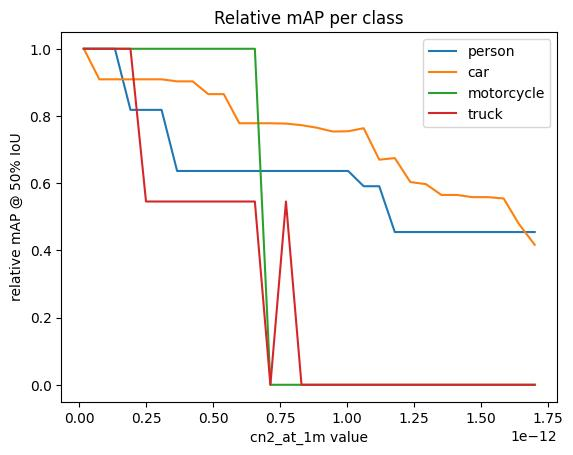

In [16]:
#
# Each instance of the metrics object has, potentially, a different set of observed classes.
# Loop through them to accumulate a unified set of classes to ensure consistent plotting across
# all thresholds.
#

unified_classes = set()
for m in perturbed_metrics:
    for class_idx in m["classes"].tolist():
        unified_classes.add(class_idx)

#
# dictionary of class_idx -> list of per-class mAP, or 0 if not present at that threshold
#

class_mAP = {class_idx: list() for class_idx in unified_classes}  # noqa: N816

#
# populate the lists across the perturbation values
#

for m in perturbed_metrics:
    this_perturbation_classes = m["classes"].tolist()
    for class_idx in unified_classes:
        if class_idx in this_perturbation_classes:
            # the index of the class in this individual metric instance
            this_class_idx = this_perturbation_classes.index(class_idx)
            class_mAP[class_idx].append(m["map_per_class"][this_class_idx].item())
        else:
            class_mAP[class_idx].append(0)

#
# plot
#

plt.title("Relative mAP per class")
plt.xlabel("cn2_at_1m value")
plt.ylabel("relative mAP @ 50% IoU")
for class_idx, class_mAP_list in class_mAP.items():  # noqa: N816
    plt.plot(perturbation_values, class_mAP_list, label=baseline[0].names[class_idx])
plt.legend()
plt.show()

This plot shows several interesting results:

- The person and car classes are much more robust to turbulence perturbations than the truck and motorcycle classes. Examination of the unperturbed and the references images suggest a few possibilities:

    - One of the truck objects gets detected as a car object in more turbulent images. While trucks and cars have obvious differences, as the image becomes more turbulent, the line between car and truck becomes blurred and results in the false detections favored towards cars. 
    - The weakness of the motorcycle class can be attributed to the smaller size of the object. While the person class is also relatively small, most person objects are in the foreground of the image that result in a large enough size to be more robust than the motorcycle class. 

Any conclusions about classification accuracy should be considered in light of these caveats. In particular, the foreground positioning of the detected person objects suggests that instead of looking at per-class results, we drill down by bounding box area. Fortunately, the metrics class supports this:


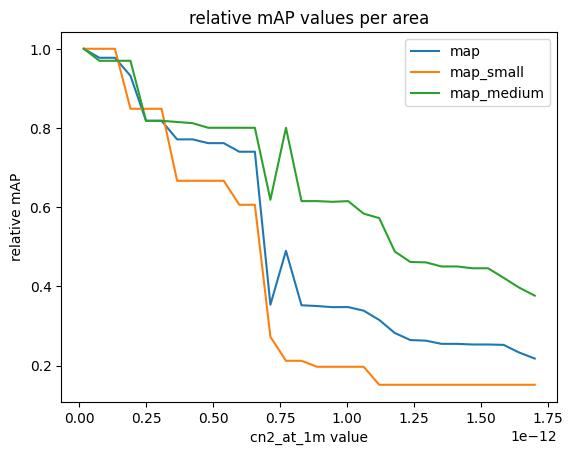

In [17]:
plt.title("relative mAP values per area")
plt.xlabel("cn2_at_1m value")
plt.ylabel("relative mAP")
for k in ("map", "map_small", "map_medium"):
    plt.plot(perturbation_values, [m[k].item() for m in perturbed_metrics], label=k)
plt.legend()
plt.show()

The `map` line covers all sizes; `map_small` and `map_medium` are the mean average precision for objects (smaller than 32^2 pixels, between 32^2 and 96^2 pixels) in area, respectively. (There are no detections in the `map_large` category.) (Here, the mAP value is averaged over a **range** of IoU thresholds, between 0.5 and 0.95.) We see that medium objects, regardless of class, are generally much more robust to more turbulent perturbations than small ones, which makes sense when observing how objects tend to get blurry in the perturbation examples shown in the [Examples and Guidance](#NRTK-Turbulence-Aperture-perturbation:-examples-and-guidance) section above.


# End of notebook